# Customer Segmentation in Marketing

In this kernel, we will analyze real-world customer data from the online education platform to perform market segmentation whcih is crucial for businesses to understand customer behavior and improve marketing efficiency. 

# Description

Can information about the acquisition channel give us insights into how much students will learn? For example, are there any geographical locations where most of our students discover the platform, specifically through social media platforms like YouTube or Facebook? Are Twitter (X) groups more or less likely to study than those from Instagram? Or are students from the US more likely to have heard about us through friends or social media?

The goal of this project is to understand if there is a relationship between different groups of customers based on the information we have about them. This analysis will group all existing members and provide insights into trends, such as overall groups behaviors from different sources. This can inform the marketing team and help determine where to invest more resources during marketing campaigns.

# Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Reading Data

In [2]:
df = pd.read_csv("/kaggle/input/customer-segmentation-data/customer_segmentation_data.csv")

# EDA
## Variables Description

| Variable          | Data type  | Range             | Description                                                                 |
|-------------------|------------|-------------------|-----------------------------------------------------------------------------|
| minutes watched   | numerical  | Integer           | The number of minutes a student has watched since joining the program       |
| CLV               | numerical  | Integer           | The Customer Lifetime Value, or CLV, shows the total amount of revenue generated by that customer |
| Region            | categorical| {0, 1, 2}         | This is the geographical region where the student comes from. <br> 0. USA, Canada, United Kingdom, Australia <br> 1. Western Europe <br> 2. Rest of the World  |
| Channel           | categorical| {1, 2, 3, 4, 5, 6, 7, 8} | This is the channel through which the customer has learned about the 365 program <br> 1. Google <br> 2. Facebook <br> 3. YouTube <br> 4. LinkedIn <br> 5. Twitter <br> 6. Instagram <br> 7. Friend <br> 8. Other  |


## High-Level Overview

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   minutes_watched  3725 non-null   float64
 1   CLV              3834 non-null   float64
 2   region           3834 non-null   int64  
 3   channel          3834 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 119.9 KB


In [4]:
df.describe()

,minutes_watched,CLV,region,channel
count,3725.000000,3834.000000,3834.000000,3834.000000
mean,1972.094497,118.383920,1.167188,3.870370
std,7401.693028,70.471274,0.923055,2.191972
min,0.000000,0.000000,0.000000,1.000000
25%,159.000000,62.580000,0.000000,2.000000
50%,512.000000,119.000000,2.000000,3.000000
75%,1521.000000,149.990000,2.000000,6.000000
max,288508.000000,626.400000,2.000000,8.000000


In [5]:
df.head()

,minutes_watched,CLV,region,channel
0,3197.0,205.42,2,4
1,63.0,149.99,0,1
2,605.0,119.00,2,2
3,20.0,240.00,2,4
4,245.0,184.36,1,4


Insights:
- ``minutes_watched`` has 109 missing values. We need to investigate why these values are missing to understand the underlying issue.
- The scale of the features is different. They should be standardized if we are using distance-based algorithms like KMeans Clustering to ensure they hold equal weight during segmentation.
- The data types of ``region`` and ``channel`` is ``int64``, but based on the variables description above, they should be considered categorical.

## Handle Missing Values

In [6]:
df.loc[df["minutes_watched"].isna()].head()

,minutes_watched,CLV,region,channel
215,NaN,300.06,0,4
368,NaN,43.82,1,3
470,NaN,150.28,0,6
545,NaN,149.99,2,3
764,NaN,62.58,2,6


In [7]:
df.loc[df["minutes_watched"].isna()].describe()

,minutes_watched,CLV,region,channel
count,0.0,109.000000,109.000000,109.000000
mean,NaN,132.736147,0.963303,4.174312
std,NaN,57.836728,0.942088,2.296713
min,NaN,36.000000,0.000000,1.000000
25%,NaN,82.040000,0.000000,3.000000
50%,NaN,119.230000,1.000000,4.000000
75%,NaN,156.000000,2.000000,6.000000
max,NaN,348.000000,2.000000,8.000000


Insights:
- These null values most likely correspond to people who have entered the program but have not seen any content. 
- Therefore, it should be appropriate to fill those missing values with zeroes. 

In [8]:
df["minutes_watched"] = df["minutes_watched"].fillna(0)

## Correlation Analysis
### Heatmap

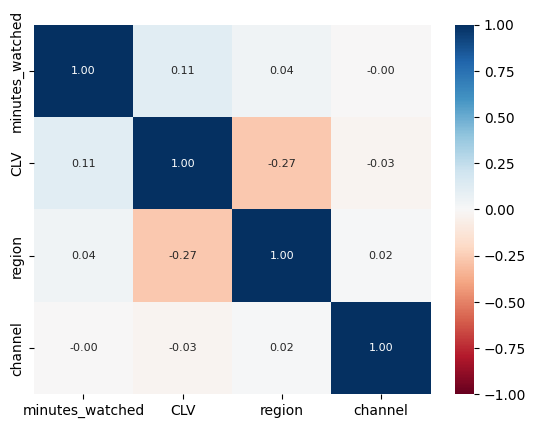

In [9]:
sns.heatmap(df.corr(), vmin = -1, vmax = 1, cmap = "RdBu", annot = True, annot_kws = {"fontsize": 8}, fmt=".2f");

Insights:
- There do not seem to be strong correlations between most feature.
- The ``CLV`` feature and the ``region`` features seem to have a slight correlation.

### Scatterplot

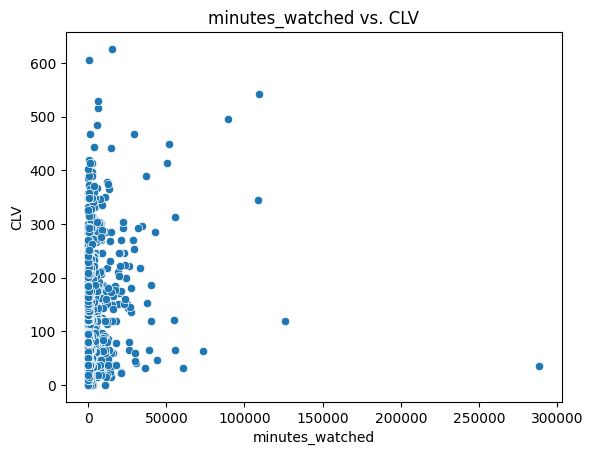

In [10]:
sns.scatterplot(data = df, x = "minutes_watched", y = "CLV")

plt.title("minutes_watched vs. CLV");

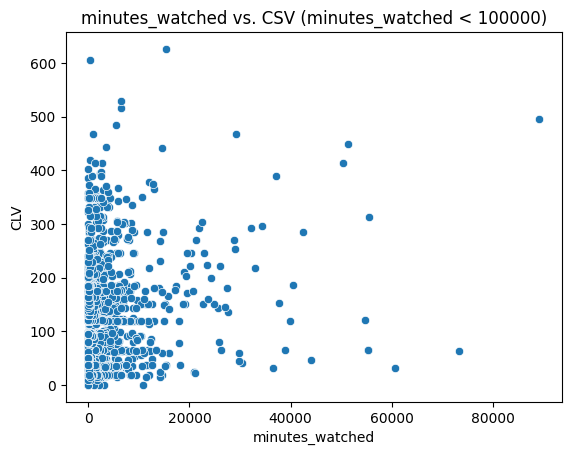

In [11]:
# Zoom-in
sns.scatterplot(data = df.loc[df["minutes_watched"] <100000], x = "minutes_watched", y = "CLV")

plt.title("minutes_watched vs. CSV (minutes_watched < 100000)");

Insights:
- Most users spent less than 200,000 minutes regardless of the total amount they have paid.
- Most users spent in a range of \\$0 - \\$400.
- There are some obvious outliers.
 - For example, one user has spent close to 300,000 minutes while only spending below \$50. 

## Convert Data Types

In [12]:
enc = pd.get_dummies(df[["region", "channel"]].astype("category"), dtype = "int")

# Remove the original ``channel`` column to avoid issues during the next part of the project. But leave the original ``region`` column in the data
df_enc = pd.concat([df, enc], axis = 1).drop("channel", axis = 1)

In [13]:
df_enc.head()

,minutes_watched,CLV,region,region_0,region_1,region_2,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8
0,3197.0,205.42,2,0,0,1,0,0,0,1,0,0,0,0
1,63.0,149.99,0,1,0,0,1,0,0,0,0,0,0,0
2,605.0,119.00,2,0,0,1,0,1,0,0,0,0,0,0
3,20.0,240.00,2,0,0,1,0,0,0,1,0,0,0,0
4,245.0,184.36,1,0,1,0,0,0,0,1,0,0,0,0


In [14]:
df_enc = df_enc.rename(columns = {'channel_1':'Google', 
                                  'channel_2':'Facebook', 
                                  'channel_3':'YouTube',
                                  'channel_4':'LinkedIn', 
                                  'channel_5':'Twitter', 
                                  'channel_6':'Instagram', 
                                  'channel_7':'Friend', 
                                  'channel_8':'Other',
                                  'region_0':'US_CA_UK_AU',
                                  'region_1':'Western_Europe',
                                  'region_2':'Rest_of_the_World'
                                  })

In [15]:
df_enc.head()

,minutes_watched,CLV,region,US_CA_UK_AU,Western_Europe,Rest_of_the_World,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other
0,3197.0,205.42,2,0,0,1,0,0,0,1,0,0,0,0
1,63.0,149.99,0,1,0,0,1,0,0,0,0,0,0,0
2,605.0,119.00,2,0,0,1,0,1,0,0,0,0,0,0
3,20.0,240.00,2,0,0,1,0,0,0,1,0,0,0,0
4,245.0,184.36,1,0,1,0,0,0,0,1,0,0,0,0


# Modeling
## Standardization

In [16]:
std = StandardScaler()

df_enc_std = std.fit_transform(df_enc)

## Hierarchical Clustering (Ward’s Method)

Ward's method is a technique used in hierarchical clustering to determine the distance between clusters. It is designed to minimize the total within-cluster variance when merging clusters. 

In [17]:
linkage_matrix = linkage(df_enc_std, method='ward')

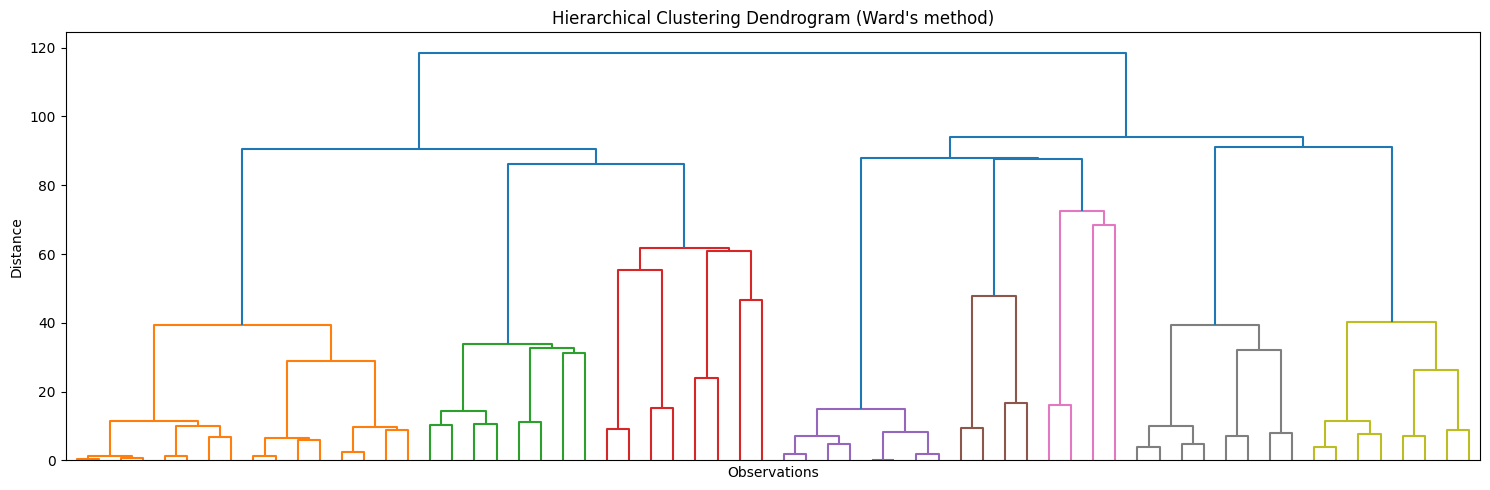

In [18]:
plt.figure(figsize=(15, 5))
dendrogram(linkage_matrix,
           truncate_mode = 'level',
           p = 5,
           show_leaf_counts = False,
           no_labels = True)
plt.title('Hierarchical Clustering Dendrogram (Ward\'s method)')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.tight_layout();

Insights:
- The results of the algorithm point to 8 separate clusters.

## K-Means Clustering
### Elbow Plot

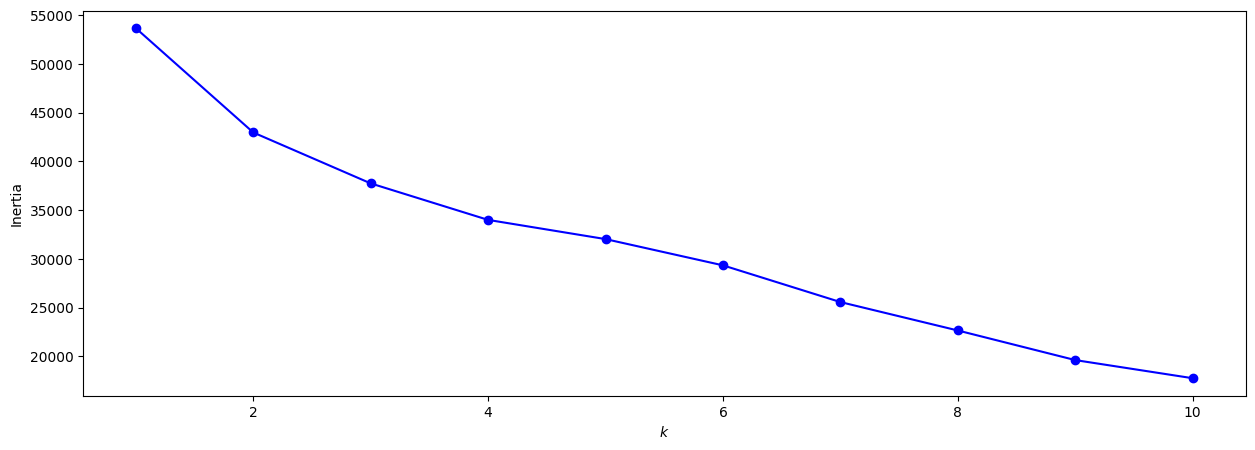

In [19]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, init = 'k-means++', random_state=42).fit(df_enc_std) for k in range(1, 11)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.show()

If we use the elbow method, we observe that the results of the k-means algorithm point to 2, 3, up to 10 different clusters. These results differ from the 8 clusters found by the hierarchical clustering.

In this case, __we will opt for the hierarchical clustering results and apply them in the k-means__ (i.e., perform k-means clustering with 8 clusters and analyze the resulting clusters using a summary table).

But first, let’s justify why we opt for this approach instead of choosing the results of the k-means and also discuss why we have obtained such vastly different results from both techniques.

#### Why K-Means and Hierarchical Clustering Might Suggest Different Numbers of Clusters?

The main reasons why k-means and hierarchical clustering might suggest different numbers of clusters are as follows:
- Different methodologies
 - Hierarchical clustering builds a tree (or dendrogram) of clusters by successively splitting or merging them. The decision to split or merge can be based on various algorithms and criteria. On the other hand, k-means tries to find a predetermined number of clusters (k) that minimizes the within-cluster variance.
- Initial setup sensitivity
 - K-means is highly sensitive to initial starting conditions (i.e., the initial placement of the centroid of each cluster). Different runs give different results. Hierarchical clustering is deterministic and will always provide the same result with the same data.
- Cluster shape
 - K-means works best with spherical and evenly sized clusters. It might not do a good job if the clusters have irregular shapes, varying sizes, or densities. Hierarchical clustering does not have these assumptions.

Finally, we opt for hierarchical clustering results because it can determine the number of clusters for us, whereas k-means doesn’t, and it’s up to us to choose them with such techniques as the elbow method.

But in cases where we have too many data points, we can no longer rely on hierarchical clustering because hierarchical clustering is computationally expensive and it becomes too inefficient. With this analysis, it is essential to note that this is the field of unsupervised machine learning where the correct answer isn’t known in advance.

The ideal number of clusters heavily depends on the data, features used, distance measures, and the specific clustering algorithm. Hierarchical and k-means clustering are different techniques that may produce different results. Also, note that the ideal number of segments might be 8 in our case but 2 for other applications.

In [20]:
# Fitting the standardized data to the KMeans algorithm with 8 clusters.
kmeans = KMeans(n_clusters = 8, n_init = 10, init = 'k-means++', random_state = 42)
kmeans.fit(df_enc_std)

KMeans(n_init=10, random_state=42)

# Model Evaluation

In [21]:
# Creating a copy of the original 'df_enc' dataframe to avoid modifying it directly.
df_kmeans = df_enc.copy()

# Assigning the cluster labels generated by k-means to a new column named 'Segment' in the copied dataframe.
df_kmeans['Segment'] = kmeans.labels_

In [22]:
pd.set_option('display.max_columns', 50)

In [23]:
df_eval = df_kmeans.groupby(['Segment']).mean()

df_eval['n_obs'] = df_kmeans[['Segment','US_CA_UK_AU']].groupby(['Segment']).count()
df_eval['prop_obs'] = df_eval['n_obs'] / df_eval['n_obs'].sum()

df_eval['minutes_watched_rank'] = df_eval['minutes_watched'].rank(ascending = False)
df_eval['CLV_rank'] = df_eval['CLV'].rank(ascending = False)

In [24]:
df_eval.round(2)

,minutes_watched,CLV,region,US_CA_UK_AU,Western_Europe,Rest_of_the_World,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,n_obs,prop_obs,minutes_watched_rank,CLV_rank
Segment,,,,,,,,,,,,,,,,,,
0,1299.33,115.18,1.19,0.31,0.19,0.50,0.00,0.0,0.00,0.00,0.0,1.0,0.00,0.00,289,0.08,7.0,3.0
1,1801.27,91.12,2.00,0.00,0.00,1.00,0.00,0.0,0.00,1.00,0.0,0.0,0.00,0.00,391,0.10,5.0,8.0
2,2018.97,109.12,1.42,0.29,0.00,0.71,0.00,0.0,0.00,0.00,0.0,0.0,1.00,0.00,424,0.11,3.0,4.0
3,2326.89,103.94,2.00,0.00,0.00,1.00,0.35,0.0,0.54,0.00,0.0,0.0,0.00,0.11,939,0.24,2.0,6.0
4,1539.15,136.33,0.00,1.00,0.00,0.00,0.25,0.0,0.43,0.18,0.0,0.0,0.00,0.14,1055,0.28,6.0,2.0
5,1874.75,157.92,1.00,0.00,1.00,0.00,0.22,0.0,0.34,0.19,0.0,0.0,0.15,0.11,372,0.10,4.0,1.0
6,985.33,93.15,1.60,0.17,0.05,0.78,0.00,0.0,0.00,0.00,1.0,0.0,0.00,0.00,58,0.02,8.0,7.0
7,2767.64,108.26,1.32,0.29,0.10,0.61,0.00,1.0,0.00,0.00,0.0,0.0,0.00,0.00,306,0.08,1.0,5.0


- __Segment 0 - Instagram Explorers__ (289 observations): 
 - These customers are from all regions, with a slightly higher proportion from the rest of the world. They have a relatively low level of engagement (ranked 7th in minutes_watched) but higher expenditure (ranked 3rd in CLV).
- __Segment 1 - LinkedIn Networkers__ (391 observations):
 - This segment consists entirely of customers from the rest of the world who heard about the platform through LinkedIn. They have moderate engagement (ranked 5th in minutes_watched) but the lowest spending (ranked 8th in CLV).
- __Segment 2 - Friends' Influence__ (424 observations):
 - This segment primarily consists of customers from the rest of the world who found the platform via friends. They have higher level of engagement (ranked 3rd in minutes_watched) and moderate spending (ranked 4th in CLV).
- __Segment 3 - Google-YouTube Users__ (939 observations):
 - These customers from the rest of the world discovered the platform via a mix of Google and YouTube. They have very high engagement (ranked 2nd in minutes_watched) and moderate spending (ranked 6th in CLV).
- __Segment 4 - NA-CA-UK-AU Multi-Channel__ (1,055 observations):
 - This segment comprises customers from the US, Canada, the UK, and Australia who discovered the platform through a mix of Google, YouTube, and LinkedIn. They have lower engagement (ranked 6th in minutes_watched) but high expenditure (ranked 2nd in CLV).
- __Segment 5 - European Multi-Channel__ (372 observations):
 - These customers are from Western Europe and heard about the platform from multiple sources, including Google, YouTube, LinkedIn, and friends. They have the highest engagement (ranked 1st in minutes_watched) and moderate spending (ranked 5th in CLV).
- __Segment 6 - Twitter Users__ (58 observations):
 - This small group of customers found the platform via Twitter (X). They are from all regions, with a majority from the rest of the world. They have the lowest level of engagement (ranked 8th in minutes_watched) and very low expenditure (ranked 7th in CLV).
- __Segment 7 - Facebook Users__ (306 observations):
 - This group mainly heard about the platform from Facebook. They are from all regions, with a higher proportion from the rest of the world. They have the highest level of engagement (ranked 1st in minutes_watched) and moderate spending (ranked 5th in CLV).

In [25]:
df_eval.rename({0:'Instagram Users',
                1:'LinkedIn Networkers',
                2:'Friends\' Influence',
                3:'Google-YouTube Users',
                4:'NA-CA-UK-AU Multi-Channel', 
                5:'European Multi-Channel',
                6:'Twitter Users',
                7:'Facebook Users', 
                })

,minutes_watched,CLV,region,US_CA_UK_AU,Western_Europe,Rest_of_the_World,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,n_obs,prop_obs,minutes_watched_rank,CLV_rank
Segment,,,,,,,,,,,,,,,,,,
Instagram Users,1299.332180,115.180277,1.186851,0.311419,0.190311,0.498270,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,289,0.075378,7.0,3.0
LinkedIn Networkers,1801.265985,91.118312,2.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.000000,391,0.101982,5.0,8.0
Friends' Influence,2018.969340,109.117382,1.419811,0.290094,0.000000,0.709906,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,424,0.110589,3.0,4.0
Google-YouTube Users,2326.887114,103.938839,2.000000,0.000000,0.000000,1.000000,0.349308,0.0,0.544196,0.000000,0.0,0.0,0.000000,0.106496,939,0.244914,2.0,6.0
NA-CA-UK-AU Multi-Channel,1539.152607,136.329469,0.000000,1.000000,0.000000,0.000000,0.248341,0.0,0.432227,0.179147,0.0,0.0,0.000000,0.140284,1055,0.275170,6.0,2.0
European Multi-Channel,1874.747312,157.922581,1.000000,0.000000,1.000000,0.000000,0.217742,0.0,0.341398,0.188172,0.0,0.0,0.145161,0.107527,372,0.097027,4.0,1.0
Twitter Users,985.327586,93.151552,1.603448,0.172414,0.051724,0.775862,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,58,0.015128,8.0,7.0
Facebook Users,2767.643791,108.260359,1.323529,0.287582,0.101307,0.611111,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,306,0.079812,1.0,5.0


# Interpretation

- The largest segment is __NA-CA-UK-AU Multi-Channel__ with 1,055 observations, making up 27.52% of the total observations. Considering this segment size and the fact that customers from this segment spend the second largest amount, this region's marketing performance is strong.
- The __Twitter Users__ group is the smallest segment, with only 58 observations. Based on the characteristics of the cluster, we conclude that our efforts on Twitter are not very frouitful. This suggests reducing spending there to a minimum and investing few resources in uploading content to the platform because the results are not satisfactory. These results may be due to the recent turmoil of the platform. Therefore, another suggestion would be for marketing to become an early adopter of a new competitor platform, like Threads.
- The __Facebook Users__ group is not the most significant segment (8% of all customers), with average spending in the lower half compared to the rest. However, this group is the most dedicated to learning, with average minutes watched of over 2,700 minutes. This indicates that high engagement does not always translate to high value. In terms of regions, 29% are from US-CA-UK-AU and over 60% from the rest of the world. While this would be the focus of a different analysis on engagementt, it would be worth exploring how these students interact with the platform and why their group is more motivated to study.
- Customers in the __European Multi-Channel__ segment are both highly engaged and have the highest CLV, making them a highly valuable segment. However, the __Western Europe__ region has the fewest customers, and this indicates that Western Europe's marketing efforts are not sufficient. Threfore, it is crucial to address this region and improve marketing performance.
- The __Google-YouTube Users__ group is the second largest segment. This group has very high level of engagement, so targeted content and ads on these platforms could be effective. 
- The __Friends' Influence__ segment highlights the power of referrals, suggesting that incentivizing referrals could be an effective strategy.

# Conclusion

Overall, the analysis underscores the importance of tailoring marketing strategies to specific segments and continuously evaluating the effectiveness of different acquisition channels. By focusing on high-value segments and optimizing marketing efforts across various platforms, the organization can enhance its overall performance and achieve better results.

I have added an additional section below as optional, but we can use the combination of K-Means and PCA. 

Thank you for reading this kernel!

Seiji

# PCA

In [26]:
segment_mapping = {0:'Instagram Users',
                   1:'LinkedIn Networkers',
                   2:'Friends\' Influence',
                   3:'Google-YouTube Users',
                   4:'NA-CA-UK-AU Multi-Channel', 
                   5:'European Multi-Channel',
                   6:'Twitter Users',
                   7:'Facebook Users', 
                   }

df_kmeans['Labels'] = df_kmeans['Segment'].map(segment_mapping)

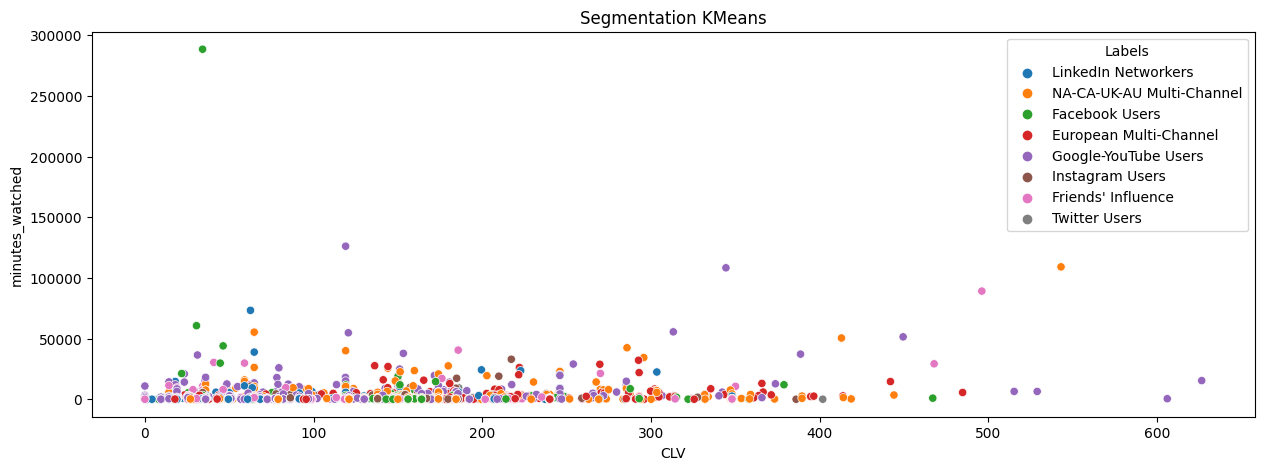

In [27]:
x_axis = df_kmeans['CLV']

y_axis = df_kmeans['minutes_watched']

plt.figure(figsize = (15, 5))

sns.scatterplot(x = x_axis, y = y_axis, hue = df_kmeans['Labels'])

plt.title('Segmentation KMeans')

plt.show()

In [28]:
pca = PCA()

pca.fit(df_enc_std)

PCA()

In [29]:
pca.explained_variance_ratio_

array([2.11891135e-01, 9.59069675e-02, 9.42731963e-02, 8.59098975e-02,
       8.28036963e-02, 7.95318365e-02, 7.90054842e-02, 7.56749302e-02,
       7.21437103e-02, 7.06071519e-02, 5.22519941e-02, 2.24324711e-32,
       9.31330487e-33, 1.81460489e-33])

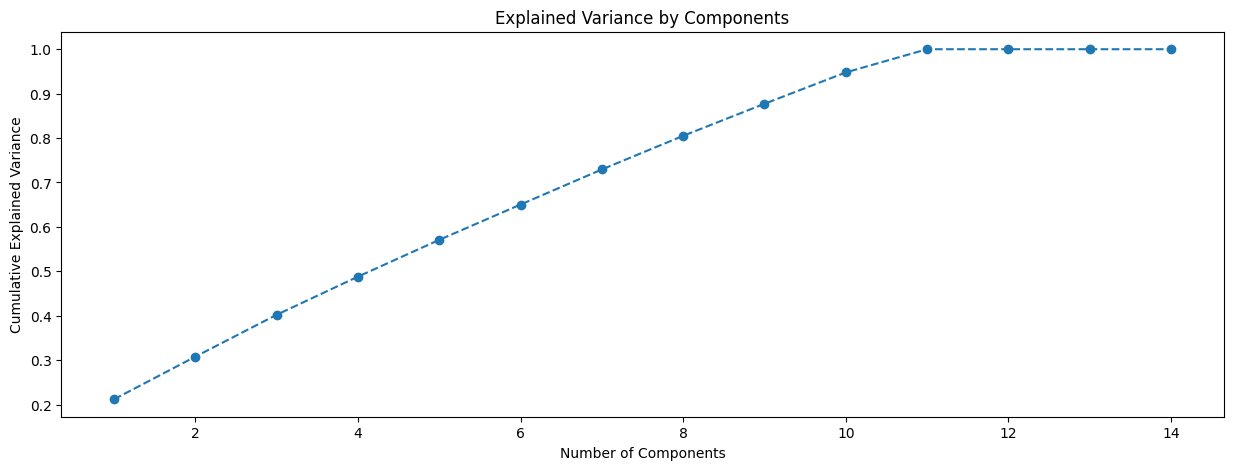

In [30]:
plt.figure(figsize = (15,5))
plt.plot(range(1,15), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show();

In [31]:
df_pca = pd.DataFrame(data = pca.components_,
                      columns = df_enc.columns.values,
                      index = ["Component 1", "Component 2", "Component 3", "Component 4", "Component 5", 
                               "Component 6", "Component 7", "Component 8", "Component 9", "Component 10", 
                               "Component 11", "Component 12", "Component 13", "Component 14"]
                     )

df_pca

,minutes_watched,CLV,region,US_CA_UK_AU,Western_Europe,Rest_of_the_World,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other
Component 1,-1.737968e-02,2.397157e-01,-0.569327,0.520254,0.083478,-0.553212,0.030952,-0.050033,0.090902,-0.075888,-0.054596,-0.005191,-0.078581,0.088085
Component 2,1.740129e-01,3.625793e-01,0.120829,-0.282623,0.489420,-0.047716,-0.246006,-0.073595,0.572144,-0.292382,-0.064336,0.054013,-0.026997,-0.124156
Component 3,4.167839e-02,2.035170e-01,0.029293,-0.225104,0.579785,-0.161713,0.286776,0.020952,-0.603079,0.077572,-0.047196,0.249030,0.124159,0.104652
Component 4,1.094009e-01,3.895666e-02,0.031660,0.020754,-0.150958,0.078404,0.668054,0.063590,0.026142,-0.685760,0.028758,-0.131449,0.090689,-0.092332
Component 5,1.034178e-01,-2.438469e-02,-0.035649,0.065174,-0.090772,-0.003382,-0.459557,0.213947,-0.157103,-0.357392,0.016282,0.051197,0.687553,0.299916
Component 6,3.241000e-01,4.620152e-02,0.017041,-0.012996,-0.010083,0.019028,-0.096762,0.738485,-0.071298,-0.065818,-0.007490,-0.034733,-0.505035,0.267285
Component 7,4.089256e-01,2.443242e-01,0.016263,-0.018680,0.008860,0.012141,0.093516,-0.033648,-0.030582,0.330309,-0.194452,-0.745382,0.242282,0.014925
Component 8,4.940254e-02,-7.700112e-03,0.068303,-0.069750,0.011584,0.059337,0.030420,-0.467206,0.036772,-0.103336,0.247865,-0.113475,-0.219177,0.794183
Component 9,3.522507e-01,2.989186e-02,0.029096,0.053869,-0.241204,0.105419,0.043205,-0.220640,0.009641,0.015215,-0.753299,0.406726,-0.046875,0.126610
Component 10,6.236619e-01,2.061342e-01,-0.026202,0.094257,-0.203222,0.041959,-0.046917,-0.187614,-0.107824,0.093168,0.552026,0.304186,-0.000627,-0.246892


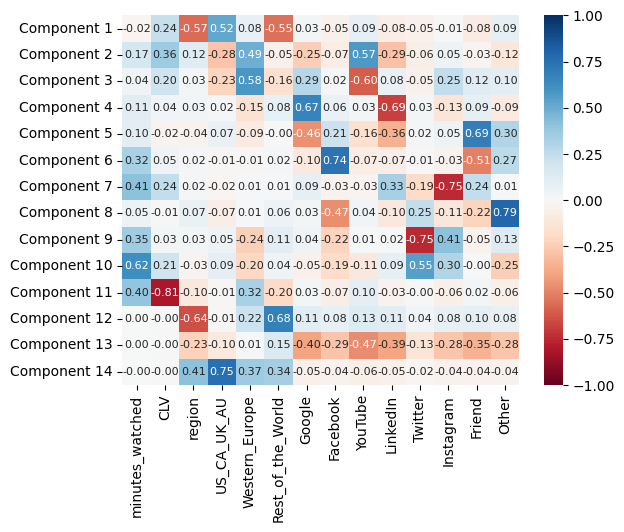

In [32]:
sns.heatmap(data = df_pca, vmin = -1, vmax = 1, cmap = "RdBu", annot = True, annot_kws = {"fontsize": 8}, fmt = ".2f");

In [33]:
scores_pca = pca.transform(df_enc_std)

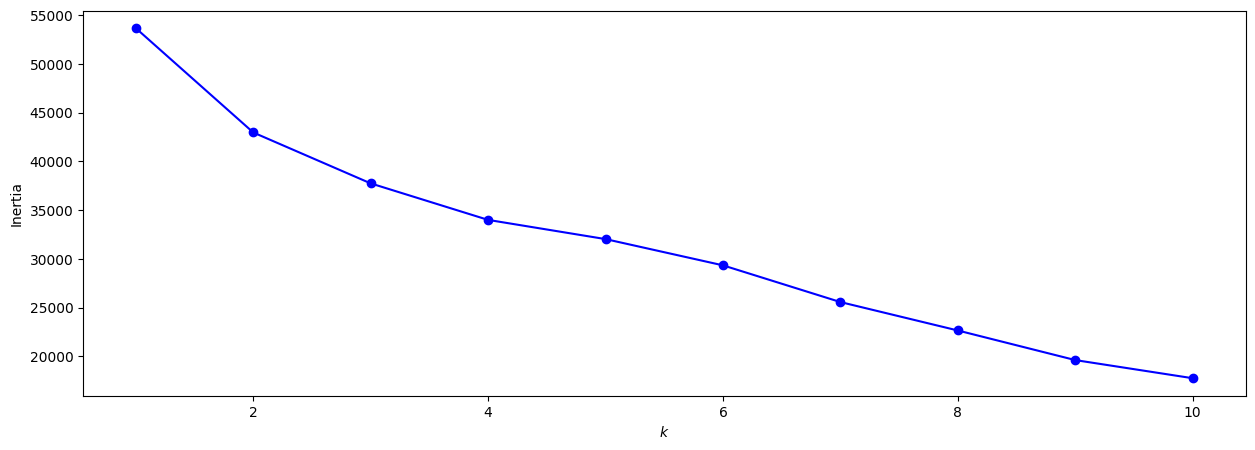

In [34]:
pca_kmeans_per_k = [KMeans(n_clusters=k, n_init=10, init = 'k-means++', random_state=42).fit(scores_pca) for k in range(1, 11)]
inertias = [model.inertia_ for model in pca_kmeans_per_k]

plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.show()

The elbow method does not seem to be helpful this time, but let's perform k-means clustering with 8 clusters as earlier.

In [35]:
kmeans_pca = KMeans(n_clusters = 8, n_init = 10, init = 'k-means++', random_state = 42)
kmeans_pca.fit(scores_pca)

KMeans(n_init=10, random_state=42)

In [36]:
df_pca_kmeans = pd.concat([df_enc.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_pca_kmeans.columns.values[-14:] = ["Component 1", "Component 2", "Component 3", "Component 4", "Component 5", 
                                      "Component 6", "Component 7", "Component 8", "Component 9", "Component 10", 
                                      "Component 11", "Component 12", "Component 13", "Component 14"] 

df_pca_kmeans["Segment Kmeans PCA"] = kmeans_pca.labels_

In [37]:
df_pca_kmeans_freq = df_pca_kmeans.groupby(["Segment Kmeans PCA"]).mean()
df_pca_kmeans_freq

,minutes_watched,CLV,region,US_CA_UK_AU,Western_Europe,Rest_of_the_World,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Component 11,Component 12,Component 13,Component 14
Segment Kmeans PCA,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1299.332180,115.180277,1.186851,0.311419,0.190311,0.498270,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,-0.053932,0.254000,1.151135,-0.553715,0.207867,-0.135449,-2.887510,-0.421055,1.438756,1.053113,-0.142721,-4.340708e-16,7.159248e-16,-2.229198e-16
1,1801.265985,91.118312,2.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.000000,-1.764069,-0.885739,0.018427,-1.707697,-0.947174,-0.124311,0.794361,-0.102235,0.190331,0.198359,-0.197896,-4.893526e-17,-7.041944e-16,4.071682e-16
2,2018.969340,109.117382,1.419811,0.290094,0.000000,0.709906,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,-0.744617,-0.309880,0.179920,0.354770,2.147302,-1.485867,0.693488,-0.610454,-0.020866,0.068605,-0.051930,1.169660e-16,-1.104531e-15,-2.475766e-16
3,2326.887114,103.938839,2.000000,0.000000,0.000000,1.000000,0.349308,0.0,0.544196,0.000000,0.0,0.0,0.000000,0.106496,-1.345868,0.385154,-0.569137,0.743196,-0.482304,0.015953,0.043097,0.568475,0.283067,-0.240364,-0.107255,-2.745497e-16,3.727859e-16,4.434137e-16
4,1539.152607,136.329469,0.000000,1.000000,0.000000,0.000000,0.248341,0.0,0.432227,0.179147,0.0,0.0,0.000000,0.140284,2.138224,-0.455398,-0.566033,0.043810,-0.255678,-0.053707,0.155089,0.182412,0.106794,0.008736,0.030115,5.582389e-16,1.893554e-16,-5.284938e-16
5,1874.747312,157.922581,1.000000,0.000000,1.000000,0.000000,0.217742,0.0,0.341398,0.188172,0.0,0.0,0.145161,0.107527,0.696256,1.790833,1.924285,-0.436621,-0.387342,-0.244644,0.443797,0.230248,-0.731814,-0.691358,0.700561,-5.167536e-17,2.078147e-16,3.403314e-16
6,985.327586,93.151552,1.603448,0.172414,0.051724,0.775862,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,-1.306786,-0.696997,-0.502602,0.279082,0.152297,-0.067291,-1.735402,2.118837,-6.138971,4.402891,-0.027462,-1.118527e-15,2.122610e-16,8.753425e-16
7,2767.643791,108.260359,1.323529,0.287582,0.101307,0.611111,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,-0.503969,-0.335528,0.093895,0.259695,0.842145,2.791991,-0.126371,-1.680705,-0.756685,-0.629718,-0.161545,-4.334237e-16,-2.159518e-16,2.418967e-16


In [38]:
df_pca_kmeans_freq['n_obs'] = df_pca_kmeans[['Segment Kmeans PCA','US_CA_UK_AU']].groupby(['Segment Kmeans PCA']).count()
df_pca_kmeans_freq['prop_obs'] = df_pca_kmeans_freq['n_obs'] / df_pca_kmeans_freq['n_obs'].sum()
df_pca_kmeans_freq

,minutes_watched,CLV,region,US_CA_UK_AU,Western_Europe,Rest_of_the_World,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Component 11,Component 12,Component 13,Component 14,n_obs,prop_obs
Segment Kmeans PCA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1299.332180,115.180277,1.186851,0.311419,0.190311,0.498270,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,-0.053932,0.254000,1.151135,-0.553715,0.207867,-0.135449,-2.887510,-0.421055,1.438756,1.053113,-0.142721,-4.340708e-16,7.159248e-16,-2.229198e-16,289,0.075378
1,1801.265985,91.118312,2.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.000000,-1.764069,-0.885739,0.018427,-1.707697,-0.947174,-0.124311,0.794361,-0.102235,0.190331,0.198359,-0.197896,-4.893526e-17,-7.041944e-16,4.071682e-16,391,0.101982
2,2018.969340,109.117382,1.419811,0.290094,0.000000,0.709906,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,-0.744617,-0.309880,0.179920,0.354770,2.147302,-1.485867,0.693488,-0.610454,-0.020866,0.068605,-0.051930,1.169660e-16,-1.104531e-15,-2.475766e-16,424,0.110589
3,2326.887114,103.938839,2.000000,0.000000,0.000000,1.000000,0.349308,0.0,0.544196,0.000000,0.0,0.0,0.000000,0.106496,-1.345868,0.385154,-0.569137,0.743196,-0.482304,0.015953,0.043097,0.568475,0.283067,-0.240364,-0.107255,-2.745497e-16,3.727859e-16,4.434137e-16,939,0.244914
4,1539.152607,136.329469,0.000000,1.000000,0.000000,0.000000,0.248341,0.0,0.432227,0.179147,0.0,0.0,0.000000,0.140284,2.138224,-0.455398,-0.566033,0.043810,-0.255678,-0.053707,0.155089,0.182412,0.106794,0.008736,0.030115,5.582389e-16,1.893554e-16,-5.284938e-16,1055,0.275170
5,1874.747312,157.922581,1.000000,0.000000,1.000000,0.000000,0.217742,0.0,0.341398,0.188172,0.0,0.0,0.145161,0.107527,0.696256,1.790833,1.924285,-0.436621,-0.387342,-0.244644,0.443797,0.230248,-0.731814,-0.691358,0.700561,-5.167536e-17,2.078147e-16,3.403314e-16,372,0.097027
6,985.327586,93.151552,1.603448,0.172414,0.051724,0.775862,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,-1.306786,-0.696997,-0.502602,0.279082,0.152297,-0.067291,-1.735402,2.118837,-6.138971,4.402891,-0.027462,-1.118527e-15,2.122610e-16,8.753425e-16,58,0.015128
7,2767.643791,108.260359,1.323529,0.287582,0.101307,0.611111,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,-0.503969,-0.335528,0.093895,0.259695,0.842145,2.791991,-0.126371,-1.680705,-0.756685,-0.629718,-0.161545,-4.334237e-16,-2.159518e-16,2.418967e-16,306,0.079812


In [39]:
segment_mapping = {0:'Instagram Users',
                   1:'LinkedIn Networkers',
                   2:'Friends\' Influence',
                   3:'Google-YouTube Users',
                   4:'NA-CA-UK-AU Multi-Channel', 
                   5:'European Multi-Channel',
                   6:'Twitter Users',
                   7:'Facebook Users', 
                   }

df_pca_kmeans['Labels'] = df_pca_kmeans['Segment Kmeans PCA'].map(segment_mapping)

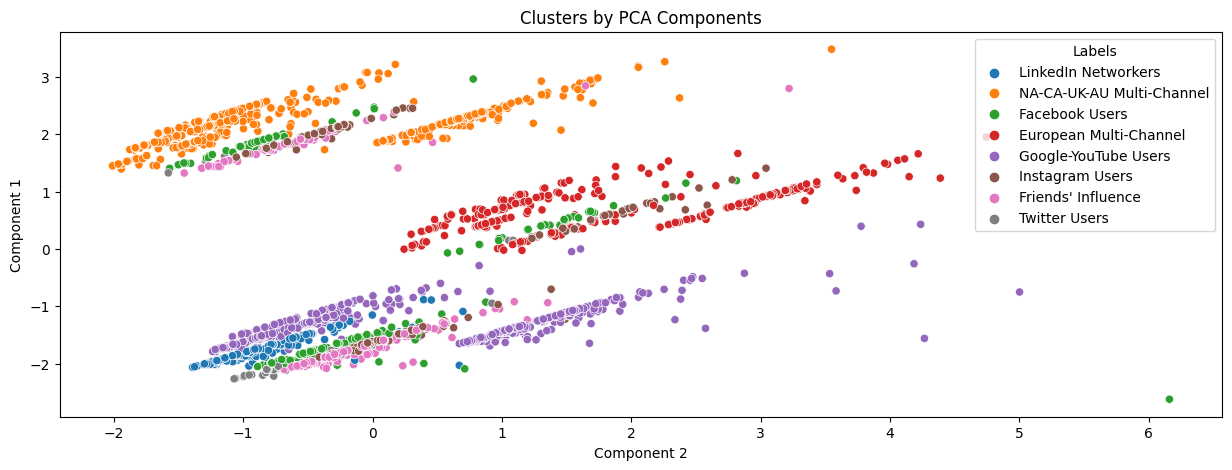

In [40]:
x_axis = df_pca_kmeans['Component 2']

y_axis = df_pca_kmeans['Component 1']

plt.figure(figsize = (15, 5))

sns.scatterplot(x = x_axis, y = y_axis, hue = df_pca_kmeans['Labels'])

plt.title('Clusters by PCA Components')

plt.show()

When we plotted the K-Means clustering solution without PCA, we were not able to distinguish each segment, but the division based on the components is much more pronounced. This is one of the biggest advantages of PCA, to reduce the number of variables by combining them into bigger, more meaningful features. They are also orthogonal to each other, meaning that the difference between components is as big as possible.

We can see some overlap between segments, but as a whole, we can observe the separation between segments. The spots where there is overlap are ultimately determined by the third component, which is not available in this graph.

One last thing to make clear is that this dataset contains only a few features, so when we further reduce the dimensionality using PCA, we found out that we only need fewer components to separate the data. That's the reason why even a two dimensional plot is enough to visually see the separation. This might not always be the case. If you have more features and more components respectively, we might need a different way to represent the results of PCA.

Thank you for reading this kernel!

Seiji